In [31]:
import joblib
import torch 
import pandas as pd
import numpy as np
from metpy.calc import wind_components
from metpy.units import units
import openmeteo_requests
import requests_cache
from math import radians, sin, cos, sqrt, atan2
from torch.utils.data import Dataset, DataLoader
from transformers import PatchTSTForPrediction, PatchTSTConfig
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib 
import matplotlib.pyplot as plt
from darts import TimeSeries
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import datetime as dt
import pytz
from retry_requests import retry
from datetime import timedelta, datetime

import torch.nn as nn
from tensorflow.keras.models import load_model
from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TinyTimeMixerForPrediction,
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def reconstruct_wind_speed_direction(df):
    """
    Given a DataFrame with Wind_U and Wind_V columns,
    returns two new columns: Wind Speed (MPS) and Wind Direction (Degrees)
    """
    df = df.copy()
    
    # Compute wind speed
    df['Wind Speed (MPS)'] = np.sqrt(df['Wind_U']**2 + df['Wind_V']**2)
    
    # Compute wind direction in meteorological convention:
    # direction from which wind is blowing (0 = North, 90 = East, 180 = South, etc.)
    df['Wind Direction (Degrees)'] = (270 - np.degrees(np.arctan2(df['Wind_V'], df['Wind_U']))) % 360

    return df

In [4]:
class RainLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(RainLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        _, (hn, _) = self.lstm(x) 
        return self.fc(hn[-1])  

In [23]:
class rain_dataset(Dataset):
    def __init__(self, df, seq_len=48, output_len=12):
        self.seq_len = seq_len
        self.output_len = output_len
        self.features = df[features].values.astype(np.float32)
        self.timestamps = df['time'].reset_index(drop=True)
        self.precip = df['Liquid Precipitation'].reset_index(drop=True).values
        self.X, self.y = [], []

        #sliding window
        for i in range(len(df) - seq_len - output_len):
            x_window = self.features[i:i+seq_len]
            y_hat = self.precip[i+seq_len:i+seq_len+output_len]

            start_time = self.timestamps[i]
            end_time = self.timestamps[i + seq_len + output_len - 1]
            expected_hours = seq_len + output_len - 1
            if (end_time - start_time).total_seconds() / 3600 != expected_hours:
                continue  

            y = float(np.sum(y_hat) > 0) 
            self.X.append(x_window)
            self.y.append(y)

        self.X = np.array(self.X, dtype=np.float32)
        self.y = np.array(self.y, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [5]:
#distance fucntion
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    return R * 2 * atan2(sqrt(a), sqrt(1 - a))

In [6]:
def get_nearest_station(location):
    names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
 
    coordinates = [            # (latitude, longitude)
    (29.5500, 35.0000),    # Aqabah
    (31.0333, 35.4667),    # Ghor
    (32.5500, 35.8500),    # Irbid
    (32.5000, 38.2000),    # Irwaished
    (30.1667, 35.7833),    # Maan
    (32.3667, 36.2500),    # Mafraq
    (31.7167, 35.9833),    # Amman
    (32.1608, 37.1539),    # Safawi
    ]
    lat, lon = location
    distances = []
    for stat_lat, stat_lon in coordinates:
        distances.append(haversine(lat, lon, stat_lat, stat_lon))
    closest_idx = int(np.argmin(distances))
    return names[closest_idx]

In [7]:

"""
This function takes a 48 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V', location (latitude, longtitude) and models and transformers directory,
returns closest station name and a single rain probability for next 12 hours
"""
def predict_rain_probability(location, df_48h, models_dir="Models/Precipitation_Models"):
    
    input_features = [
    'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
    'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
    ]
    
    #Find closest station
    station = get_nearest_station(location)

    #Load model and scaler
    scaler = joblib.load(f"{models_dir}/{station}_scaler.pkl")
    model = RainLSTM(input_size=11)
    model.load_state_dict(torch.load(f"{models_dir}/{station}_precipitation_model.pth", map_location=torch.device('cpu')))
    model.eval()

    #preprocessing 
    df = df_48h.copy()
    df['hour'] = df['time'].dt.hour
    df['day_yr'] = df['time'].dt.dayofyear
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_yr'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_yr'] / 365)

    df[input_features] = scaler.transform(df[input_features])
    input_data = df[input_features].values.astype(np.float32)

    #Padding just in case
    if len(input_data) < 48:
        pad_len = 48 - len(input_data)
        padding = np.repeat(input_data[-1:], pad_len, axis=0)
        input_data = np.vstack([input_data, padding])

    input_tensor = torch.tensor(input_data).unsqueeze(0)  #shape (1, 48, 11)

    with torch.no_grad():
        prob = model(input_tensor).item()

    return {
        "closest_station": station,
        "precipitation_probability": round(prob, 4)
    }

In [8]:
"""
This function takes a 48 hours of input features :'Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
'Atmospheric Pressure', 'Cloud Cover %', 'Wind_U', 'Wind_V', location (latitude, longtitude) and models and transformers directory,
returns cloud cover for next 24 hour time stamps
"""

def predict_cloud_cover(location, df_48h):
    names = ['aqaba', 'ghor', 'irbid', 'irwaished', 'maan', 'mafraq', 'amman', 'safawi']
    coordinates = [
        (29.5500, 35.0000), (31.0333, 35.4667), (32.5500, 35.8500), (32.5000, 38.2000),
        (30.1667, 35.7833), (32.3667, 36.2500), (31.7167, 35.9833), (32.1608, 37.1539),
    ]
    
    station = get_nearest_station(location)
    input_scaler = joblib.load(f"Models/Cloud_Cover_Models/{station}_input_scaler.save")
    target_scaler = joblib.load(f"Models/Cloud_Cover_Models/{station}_target_scaler.save")
    model = load_model(f"Models/Cloud_Cover_Models/{station}_cloud_model.keras")

    #Preprocess input dataframe
    df = df_48h.copy()
   

    df['hour'] = df['time'].dt.hour
    df['month'] = df['time'].dt.month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    input_features = ['Air Dew Point', 'Air Temperature (OC)', 'Humidity %',
                      'Atmospheric Pressure', 'Wind_U', 'Wind_V']
    X_input = input_scaler.transform(df[input_features])
    X_input = np.expand_dims(X_input, axis=0)  # Shape: (1, 48, 6)

    y_pred_scaled = model.predict(X_input)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    
    return y_pred.flatten()  # Shape: (24,)

In [9]:
def Cloud_and_Precipitation(df_120h, location):
    all_cloud_preds = []
    #Predict cloud first
    for step in [0, 24, 48, 72, 96]:
        df_window = df_120h.iloc[step:step + 48].copy()
        cloud_preds = predict_cloud_cover(location, df_window)  
        all_cloud_preds.extend(cloud_preds)


    assert len(all_cloud_preds) == 120, f"Expected 120 cloud preds, got {len(all_cloud_preds)}"


    df_with_cloud = df_120h.copy()
    df_with_cloud['Cloud Cover %'] = 0.0  # ensure float type
    cloud_col_index = df_with_cloud.columns.get_loc('Cloud Cover %')


    df_with_cloud.iloc[-120:, cloud_col_index] = all_cloud_preds

    #predict rain probs
    rain_probs = [] 

    for step in range(0, 109, 12):  # steps: 0, 12, ..., 72
        df_window = df_with_cloud.iloc[step:step + 48].copy()
        prob = predict_rain_probability(location, df_window)["precipitation_probability"]
        rain_probs.append(prob)

    
    day_night_tuples = [
        (rain_probs[i], rain_probs[i + 1]) for i in range(0, len(rain_probs), 2)
    ]

    return {
        "cloud_cover": all_cloud_preds,           #120 values (5x24h)
        "rain_probabilities": day_night_tuples    #5 tuples (day, night)
    }

In [10]:
def predict_TTM(df_512, station):
    # Constants
    target_columns = ["Air Dew Point", "Air Temperature (OC)", "Humidity %", 
                      "Atmospheric Pressure", "Wind_U", "Wind_V"]
    context_length = 512
    prediction_length = 96
    df_512["Unnamed: 0"] = df_512.index

    # Paths
    BASE_DIR = f'TTM Model/{station.replace(" ", "_")}/eval'
    CHECKPOINT_PATH = os.path.join(BASE_DIR, "output", "checkpoint-14715")
    PREPROCESSOR_PATH = os.path.join(BASE_DIR, "trained_preprocessor.joblib")

    # Load preprocessor and model
    tsp = joblib.load(PREPROCESSOR_PATH)
    model = TinyTimeMixerForPrediction.from_pretrained(CHECKPOINT_PATH)

    # Create inference pipeline
    inference_pipeline = TimeSeriesForecastingPipeline(
        model=model,
        device="cuda" if torch.cuda.is_available() else "cpu",
        feature_extractor=tsp,
        batch_size=512,
        freq="h"
    )

    # ---- First prediction (96h) ----
    forecast_df1 = inference_pipeline(df_512)
    prediction_columns = [col for col in forecast_df1.columns if col.endswith('_prediction')]
    predictions1 = {col.replace('_prediction', ''): forecast_df1[col].iloc[0] for col in prediction_columns}
    start_time = pd.to_datetime(df_512["Unnamed: 0"].iloc[-1]) + pd.Timedelta(hours=1)
    prediction_index1 = pd.date_range(start=start_time, periods=96, freq="h")
    forecast_output1 = pd.DataFrame(predictions1, index=prediction_index1)

    # ---- Second prediction (24h) ----
    # Extend the input with the first prediction to get the next 24h
    df_extended = pd.concat([df_512[target_columns], forecast_output1], axis=0)
    df_extended = df_extended.iloc[-512:]
    df_extended["Unnamed: 0"] = df_extended.index

    forecast_df2 = inference_pipeline(df_extended)
    predictions2 = {col.replace('_prediction', ''): forecast_df2[col].iloc[0][:24] for col in prediction_columns}
    prediction_index2 = pd.date_range(start=prediction_index1[-1] + pd.Timedelta(hours=1), periods=24, freq="h")
    forecast_output2 = pd.DataFrame(predictions2, index=prediction_index2)

    # Combine both
    final_forecast = pd.concat([forecast_output1, forecast_output2])
    final_forecast.index.name = "datetime"

    return final_forecast

In [57]:
def predict_TTM_Origional(df_512, station):
    # Constants
    target_columns = ["Air Dew Point", "Air Temperature (OC)", "Humidity %", 
                      "Atmospheric Pressure", "Wind_U", "Wind_V"]
    context_length = 512
    prediction_length = 96
    df_512["Unnamed: 0"] = df_512.index

    # Paths
    BASE_DIR = f'TTM Model/{station.replace(" ", "_")}/eval'
    CHECKPOINT_PATH = os.path.join(BASE_DIR, "output", "checkpoint-14715")
    PREPROCESSOR_PATH = os.path.join(BASE_DIR, "trained_preprocessor.joblib")

    # Load preprocessor and model
    tsp = joblib.load(PREPROCESSOR_PATH)
    model = TinyTimeMixerForPrediction.from_pretrained(CHECKPOINT_PATH)

    # Create inference pipeline
    inference_pipeline = TimeSeriesForecastingPipeline(
        model=model,
        device="cuda" if torch.cuda.is_available() else "cpu",
        feature_extractor=tsp,
        batch_size=512,
        freq="h"
    )

    # ---- First prediction (96h) ----
    forecast_df1 = inference_pipeline(df_512)
    prediction_columns = [col for col in forecast_df1.columns if col.endswith('_prediction')]
    predictions1 = {col.replace('_prediction', ''): forecast_df1[col].iloc[0] for col in prediction_columns}
    start_time = pd.to_datetime(df_512["Unnamed: 0"].iloc[-1]) + pd.Timedelta(hours=1)
    prediction_index1 = pd.date_range(start=start_time, periods=96, freq="h")
    forecast_output1 = pd.DataFrame(predictions1, index=prediction_index1)
    
    return forecast_output1

In [11]:
def predict_full_forecast(location: tuple):
    station = get_nearest_station(location)

    # past_data = get_reading("https://api.open-meteo.com/v1/forecast",
    #         location[0], location[1],
    #         ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
    #        "pressure_msl", "wind_speed_10m", "wind_direction_10m"], 4,
    #         0)
    past_data = get_realtime_5days("https://api.open-meteo.com/v1/forecast",
            location[0], location[1],
            ["temperature_2m", "dew_point_2m", "relative_humidity_2m",
           "pressure_msl", "wind_speed_10m", "wind_direction_10m"])
    # past_data = past_data.tail(72)
    TTM_preds = predict_TTM(past_data, station)
    input_with_time = TTM_preds.copy()
    input_with_time['time'] = TTM_preds.index
    cloud_precipitation = Cloud_and_Precipitation(input_with_time.tail(120),location)

    time_series_outputs = TTM_preds
    time_series_outputs['Cloud Cover %'] = cloud_precipitation['cloud_cover']

    final_df = reconstruct_wind_speed_direction(time_series_outputs)
    final_df.drop(['Wind_U', 'Wind_V'], axis = 1, inplace = True)
    forecast = {
        "time_series" : final_df,
        'rain_probabilities' : cloud_precipitation['rain_probabilities']
    }
    
    return forecast

In [69]:
test_df = pd.read_csv('Amman_test_data/amman_test.csv')

In [70]:
test_df

,Unnamed: 0,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Liquid Precipitation,Cloud Cover %,Wind_U,Wind_V
0,2023-12-31 01:00:00,6.613333,7.0,93.352226,1022.429993,0.0,0.0,-1.208667,1.516667
1,2023-12-31 02:00:00,6.613333,6.0,100.000000,1022.429993,0.0,0.0,-1.208667,1.516667
2,2023-12-31 03:00:00,6.613333,5.4,93.923673,1022.429993,0.0,37.5,-1.208667,1.516667
3,2023-12-31 04:00:00,6.613333,5.0,100.000000,1022.429993,0.0,0.0,-1.208667,1.516667
4,2023-12-31 05:00:00,6.613333,5.0,100.000000,1022.429993,0.0,0.0,-1.208667,1.516667
...,...,...,...,...,...,...,...,...,...
3640,2024-05-30 17:00:00,9.733333,21.0,52.802638,1013.019989,0.0,0.0,5.552000,-1.723333
3641,2024-05-30 18:00:00,9.733333,19.4,53.092129,1013.019989,0.0,25.0,5.552000,-1.723333
3642,2024-05-30 19:00:00,9.733333,17.0,67.769404,1013.019989,0.0,0.0,5.552000,-1.723333
3643,2024-05-30 20:00:00,9.733333,17.0,72.401375,1013.019989,0.0,0.0,5.552000,-1.723333


# Cloud Cover

In [18]:
test_df['Cloud Cover %'] = test_df['Cloud Cover %'].rolling(window=9, center=True).mean().fillna(method='bfill').fillna(method='ffill')

C:\Users\20210291\AppData\Local\Temp\ipykernel_10284\375538199.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df['Cloud Cover %'] = test_df['Cloud Cover %'].rolling(window=9, center=True).mean().fillna(method='bfill').fillna(method='ffill')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

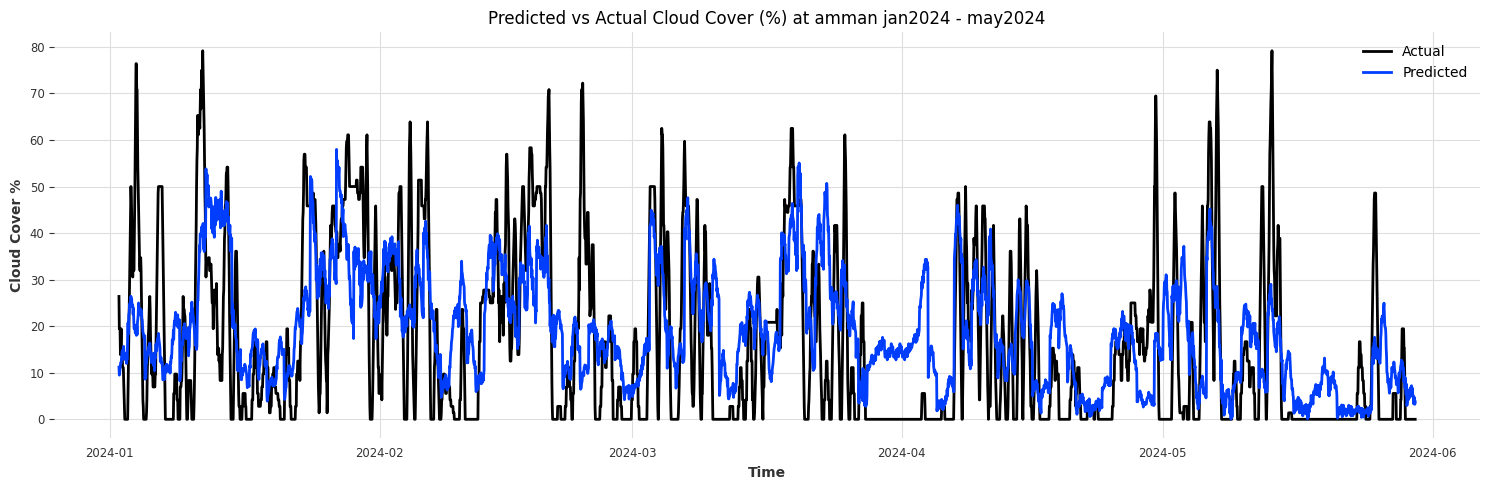

📊 Error Summary:
MAE:  12.25
RMSE: 15.42
R²:   0.31


In [21]:
def sliding_window_prediction(test_df, location):
    input_len = 48
    output_len = 24
    predictions = []
    actuals = []
    timestamps = []

    # Ensure datetime format and sorting
    test_df = test_df.copy()
    test_df['time'] = pd.to_datetime(test_df['Unnamed: 0'])
    test_df = test_df.sort_values('time').reset_index(drop=True)

    for i in range(0, len(test_df) - input_len - output_len + 1, output_len):
        df_input = test_df.iloc[i:i + input_len]
        df_actual = test_df.iloc[i + input_len:i + input_len + output_len]

        if len(df_input) == input_len and len(df_actual) == output_len:
            y_pred = predict_cloud_cover(location, df_input)
            predictions.extend(y_pred)
            actuals.extend(df_actual['Cloud Cover %'].values)
            timestamps.extend(df_actual['time'].values)

    return np.array(timestamps), np.array(predictions), np.array(actuals)

# Call prediction pipeline
location = (31.990534, 35.907787)  # Change to any desired location
timestamps, y_pred, y_true = sliding_window_prediction(test_df, location)

plt.figure(figsize=(15, 5))
plt.plot(timestamps, y_true, label='Actual', linewidth=2)
plt.plot(timestamps, y_pred, label='Predicted', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Cloud Cover %")
plt.title(f"Predicted vs Actual Cloud Cover (%) at {get_nearest_station(location)} jan2024 - may2024")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig(f"Plots/cloud_cover_prediction_{get_nearest_station(location)}.png", dpi=300)

# Show the plot
plt.show()

# Summarize errors


In [22]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("📊 Error Summary:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

📊 Error Summary:
MAE:  12.25
RMSE: 15.42
R²:   0.31


# Rain

In [39]:
test_rain = test_df.copy()
test_rain['Unnamed: 0'] = pd.to_datetime(test_rain['Unnamed: 0'])
test_rain.set_index('Unnamed: 0', inplace = True)
test_rain = test_rain[test_rain.index < pd.to_datetime('2024-03-31')]
test_rain.tail()

,Air Dew Point,Air Temperature (OC),Humidity %,Atmospheric Pressure,Liquid Precipitation,Cloud Cover %,Wind_U,Wind_V
Unnamed: 0,,,,,,,,
2024-03-30 19:00:00,3.0,21.0,30.517431,1017.5,0.0,0.0,-3.85,-1.4
2024-03-30 20:00:00,3.0,21.0,30.517431,1017.5,0.0,0.0,-3.85,-1.4
2024-03-30 21:00:00,3.0,21.0,30.517431,1017.5,0.0,0.0,-3.85,-1.4
2024-03-30 22:00:00,3.0,21.0,30.517431,1017.5,0.0,0.0,-3.85,-1.4
2024-03-30 23:00:00,3.0,21.0,30.517431,1017.5,0.0,0.0,-3.85,-1.4


In [51]:
def sliding_window_rain_prediction(test_df, location):
    input_len = 48
    output_len = 12
    predictions = []
    actuals = []
    timestamps = []

    # Ensure datetime format and sorting
    df = test_df.copy()
    df['time'] = pd.to_datetime(df['Unnamed: 0'])
    df = df.sort_values('time').reset_index(drop=True)

    for i in range(0, len(df) - input_len - output_len + 1, output_len):
        df_input = df.iloc[i:i + input_len]
        df_future = df.iloc[i + input_len:i + input_len + output_len]

        if len(df_input) == input_len and len(df_future) == output_len:
            result = predict_rain_probability(location, df_input)
            prob = result["precipitation_probability"]

            # Actual label: 1 if any precipitation > 0
            rain_future = df_future['Liquid Precipitation'].values
            rain_label = int(np.any(rain_future > 0))

            predictions.append(prob)
            actuals.append(rain_label)
            timestamps.append(df_future['time'].iloc[0])  # start of forecast window

    return np.array(timestamps), np.array(predictions), np.array(actuals)

# Run predictions

location = (31.990534, 35.907787)  # change if needed
timestamps, probs, labels = sliding_window_rain_prediction(test_rain, location)

C:\Users\20210291\AppData\Local\Temp\ipykernel_10284\2649577870.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{models_dir}/{station

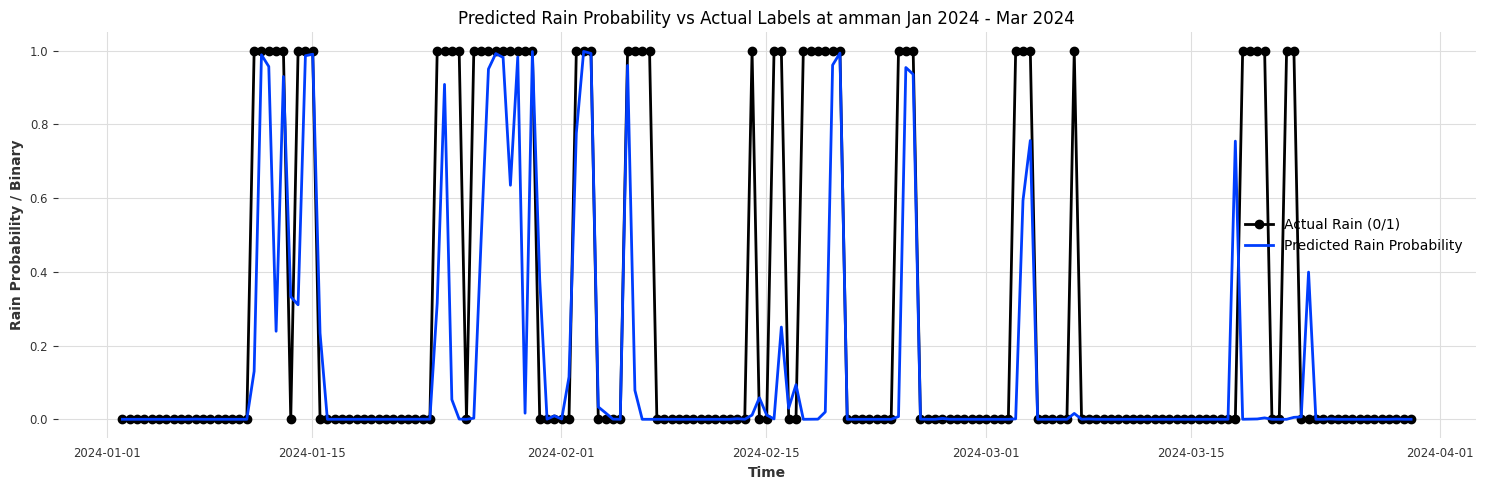

In [55]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(timestamps, labels, label='Actual Rain (0/1)', linewidth=2, marker='o')
plt.plot(timestamps, probs, label='Predicted Rain Probability', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Rain Probability / Binary")
plt.title(f"Predicted Rain Probability vs Actual Labels at {get_nearest_station(location)} Jan 2024 - Mar 2024")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(f"Plots/rain_probability_prediction_{get_nearest_station(location)}.png", dpi=300)
plt.show()

# Threshold predictions
threshold = 0.5
predicted_labels = (probs >= threshold).astype(int)

# Evaluate
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels, zero_division=0)
recall = recall_score(labels, predicted_labels, zero_division=0)
f1 = f1_score(labels, predicted_labels, zero_division=0)
roc_auc = roc_auc_score(labels, probs)



In [56]:
threshold = 0.1
predicted_labels = (probs >= threshold).astype(int)

# Evaluate classification performance
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels, zero_division=0)
recall = recall_score(labels, predicted_labels, zero_division=0)
f1 = f1_score(labels, predicted_labels, zero_division=0)
roc_auc = roc_auc_score(labels, probs)

print("📊 Rain Prediction Performance (Threshold = 0.3):")
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print(f"ROC AUC:   {roc_auc:.2f}")

📊 Rain Prediction Performance (Threshold = 0.3):
Accuracy:  0.84
Precision: 0.82
Recall:    0.56
F1 Score:  0.67
ROC AUC:   0.90


# TTM - Other vars

In [74]:
def predict_TTM(df_512, station):
    # Constants
    target_columns = ["Air Dew Point", "Air Temperature (OC)", "Humidity %", 
                      "Atmospheric Pressure", "Wind_U", "Wind_V"]
    context_length = 512
    prediction_length = 96
    df_512["Unnamed: 0"] = df_512.index

    # Paths
    BASE_DIR = f'TTM Model/{station.replace(" ", "_")}/eval'
    CHECKPOINT_PATH = os.path.join(BASE_DIR, "output", "checkpoint-14715")
    PREPROCESSOR_PATH = os.path.join(BASE_DIR, "trained_preprocessor.joblib")

    # Load preprocessor and model
    tsp = joblib.load(PREPROCESSOR_PATH)
    model = TinyTimeMixerForPrediction.from_pretrained(CHECKPOINT_PATH)

    # Create inference pipeline
    inference_pipeline = TimeSeriesForecastingPipeline(
        model=model,
        device="cuda" if torch.cuda.is_available() else "cpu",
        feature_extractor=tsp,
        batch_size=512,
        freq="h"
    )

    # ---- First prediction (96h) ----
    forecast_df1 = inference_pipeline(df_512)
    prediction_columns = [col for col in forecast_df1.columns if col.endswith('_prediction')]
    predictions1 = {col.replace('_prediction', ''): forecast_df1[col].iloc[0] for col in prediction_columns}
    start_time = pd.to_datetime(df_512["Unnamed: 0"].iloc[-1]) + pd.Timedelta(hours=1)
    prediction_index1 = pd.date_range(start=start_time, periods=96, freq="h")
    forecast_output1 = pd.DataFrame(predictions1, index=prediction_index1)

    # ---- Second prediction (24h) ----
    # Extend the input with the first prediction to get the next 24h
    df_extended = pd.concat([df_512[target_columns], forecast_output1], axis=0)
    df_extended = df_extended.iloc[-512:]
    df_extended["Unnamed: 0"] = df_extended.index

    forecast_df2 = inference_pipeline(df_extended)
    predictions2 = {col.replace('_prediction', ''): forecast_df2[col].iloc[0][:24] for col in prediction_columns}
    prediction_index2 = pd.date_range(start=prediction_index1[-1] + pd.Timedelta(hours=1), periods=24, freq="h")
    forecast_output2 = pd.DataFrame(predictions2, index=prediction_index2)

    # Combine both
    final_forecast = pd.concat([forecast_output1, forecast_output2])
    final_forecast.index.name = "datetime"

    return final_forecast

In [82]:
def sliding_window_TTM_forecast(test_df, station):
    target_columns = ["Air Dew Point", "Air Temperature (OC)", "Humidity %", 
                      "Atmospheric Pressure", "Wind_U", "Wind_V"]
    
    context_length = 512
    step = 96
    total_predictions = []
    actuals = []

    for start in range(0, len(test_df) - context_length - 120 + 1, step):
        input_df = test_df.iloc[start:start+context_length].copy()
        true_values = test_df.iloc[start+context_length:start+context_length+120][target_columns]
        preds = predict_TTM(input_df, station)

        # Align predictions with actuals
        preds = preds[target_columns].iloc[:len(true_values)]
        true_values = true_values.iloc[:len(preds)]

        total_predictions.append(preds)
        actuals.append(true_values)

    y_pred = pd.concat(total_predictions)
    y_true = pd.concat(actuals)

    # Plotting
    for col in target_columns:
        plt.figure(figsize=(12, 4))
        plt.plot(y_true.index, y_true[col], label="Actual")
        plt.plot(y_pred.index, y_pred[col], label="Predicted")
        plt.title(f"{col} - Actual vs Predicted for {station} Jan 2024 - May 2024")
        plt.xlabel("Time")
        plt.ylabel(col)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"Plots/TTM_{col}_{station}.png", dpi=300)
        plt.show()

    # Accuracy metrics
    metrics = {}
    for col in target_columns:
        mae = mean_absolute_error(y_true[col], y_pred[col])
        rmse = mean_squared_error(y_true[col], y_pred[col])
        r2 = r2_score(y_true[col], y_pred[col])
        metrics[col] = {"MAE": mae, "RMSE": rmse, "R2": r2}

    # Overall metrics
    all_mae = mean_absolute_error(y_true.values.flatten(), y_pred.values.flatten())
    all_rmse = mean_squared_error(y_true.values.flatten(), y_pred.values.flatten())
    all_r2 = r2_score(y_true.values.flatten(), y_pred.values.flatten())
    metrics["Overall"] = {"MAE": all_mae, "RMSE": all_rmse, "R2": all_r2}

    print("\n--- Accuracy Metrics ---")
    for key, val in metrics.items():
        print(f"\n{key}")
        for metric, score in val.items():
            print(f"{metric}: {score:.4f}")

    return y_true, y_pred, metrics

Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda
Device set to use cuda


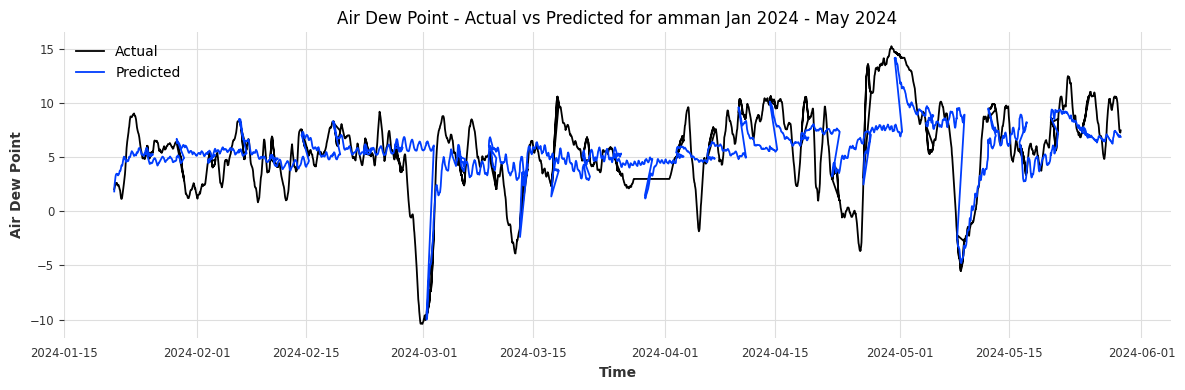

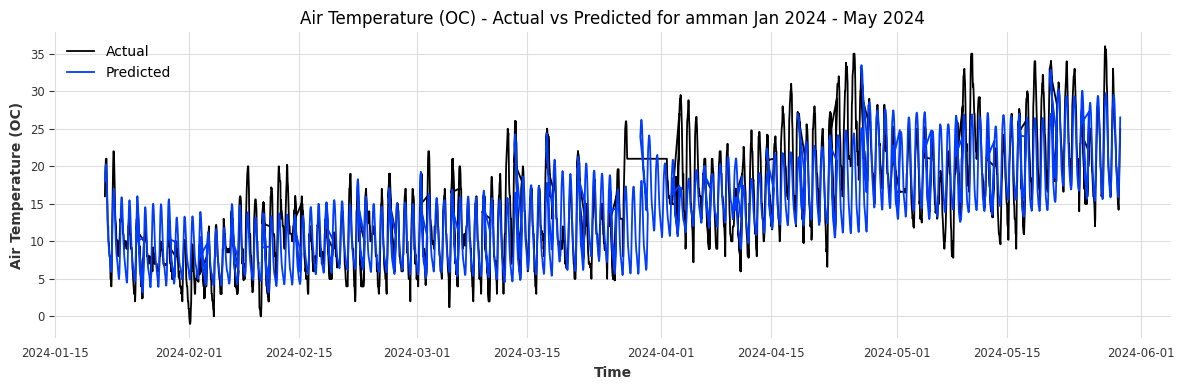

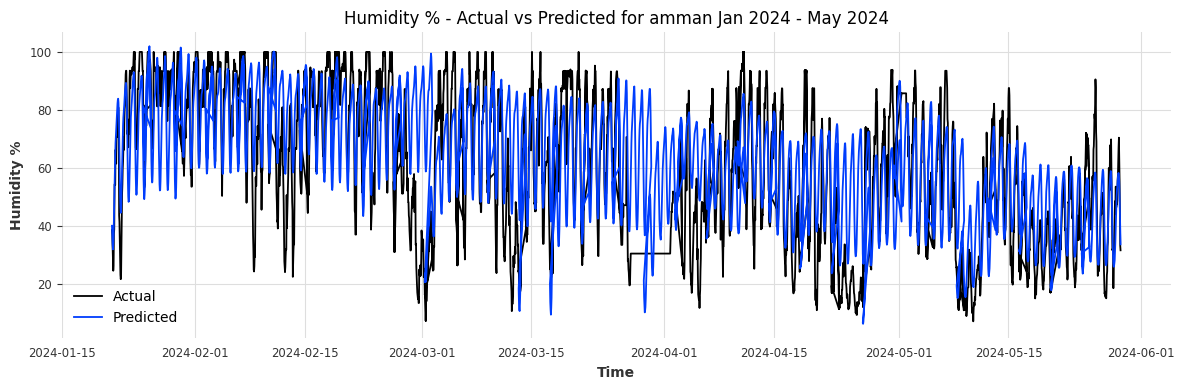

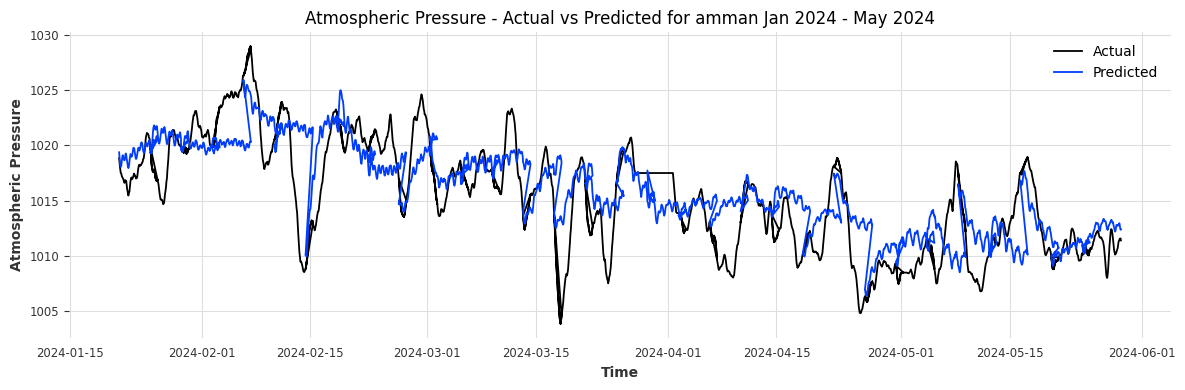

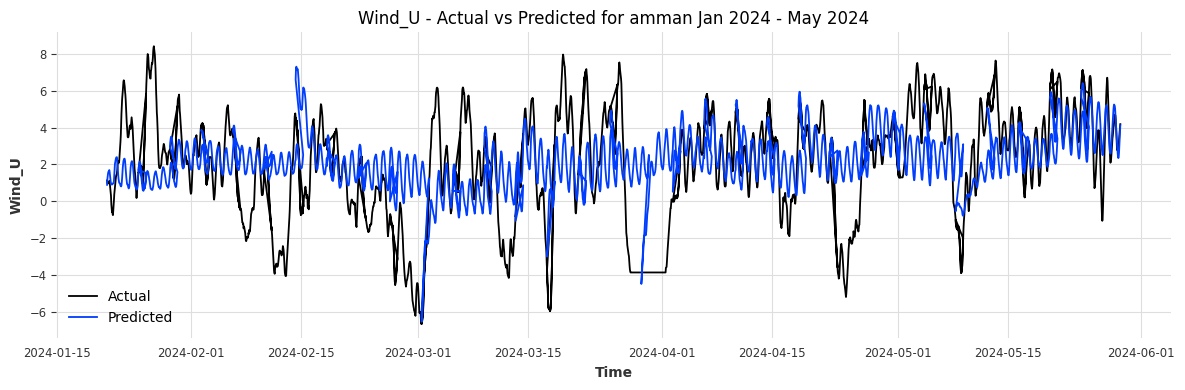

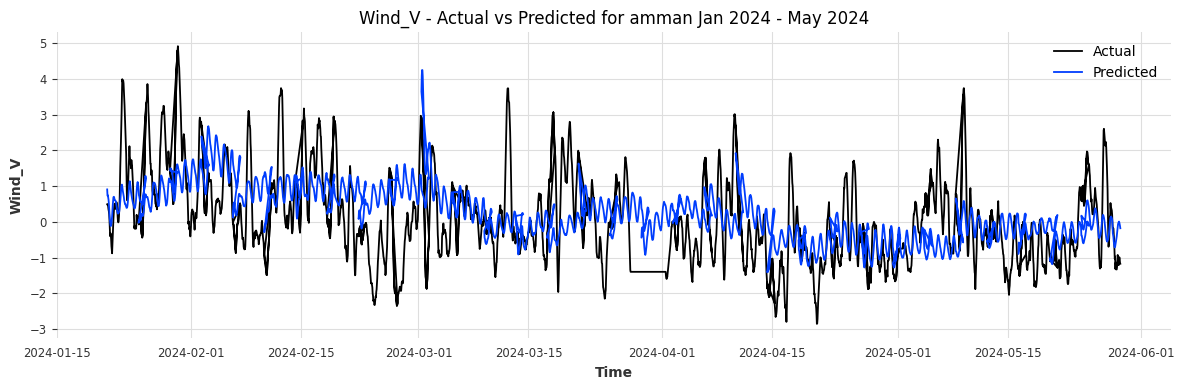


--- Accuracy Metrics ---

Air Dew Point
MAE: 2.2736
RMSE: 11.1990
R2: 0.2891

Air Temperature (OC)
MAE: 2.8371
RMSE: 14.2593
R2: 0.7242

Humidity %
MAE: 13.9163
RMSE: 330.2237
R2: 0.4888

Atmospheric Pressure
MAE: 2.5208
RMSE: 11.4058
R2: 0.5307

Wind_U
MAE: 2.0715
RMSE: 7.4949
R2: 0.1623

Wind_V
MAE: 0.9228
RMSE: 1.3833
R2: 0.1101

Overall
MAE: 4.0904
RMSE: 62.6610
R2: 0.9995


In [83]:
test_df = pd.read_csv("Amman_test_data/amman_test.csv", parse_dates=["Unnamed: 0"], index_col="Unnamed: 0")
test_df.index = pd.to_datetime(test_df.index)
station_name = "amman"
y_true, y_pred, metrics = sliding_window_TTM_forecast(test_df, station_name)